In [127]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

In [100]:
import numpy as np
import pandas as pd

In [101]:
import datetime as dt
from datetime import datetime, timedelta
from sqlalchemy import extract
from scipy import stats
import warnings
warnings.filterwarnings("ignore")


# Reflect Tables into SQLAlchemy ORM

In [102]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,desc,cast

In [103]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [104]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [105]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [106]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [107]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2017-08-23 00:00:00
2016-08-23


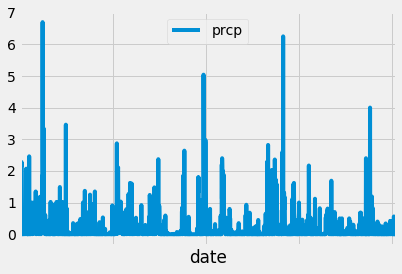

<Figure size 432x288 with 0 Axes>

In [112]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last= session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_date = dt.datetime.strptime(last[0],"%Y-%m-%d")
print(last_date)
year_old_date = last_date-dt.timedelta(days=365)
year_old_date = dt.datetime.strftime(year_old_date, "%Y-%m-%d")
print(year_old_date)


# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= year_old_date).all()

#print(results)

# Save the query results as a Pandas DataFrame and set the index to the date column

df=pd.DataFrame(results,columns= ['date','prcp'])
df.set_index('date',inplace=True)
df = df.dropna()
#df.head(10)

# Sort the dataframe by date
df = df.sort_values('date')
df.head(10)

# Use Pandas Plotting with Matplotlib to plot the data

df.plot()
plt.tick_params(labelbottom=False)
plt.legend(loc='upper center')
plt.show()



![precipitation](Images/precipitation.png)

In [113]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [114]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [115]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#session.query(Measurement.station).count()
session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
#print(results)


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [116]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()



[(54.0, 85.0, 71.66378066378067)]

[]

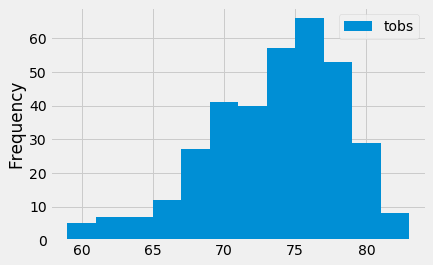

In [121]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_old_date).filter(Measurement.date <= last_date).\
    filter(Measurement.station == 'USC00519281').all()


df=pd.DataFrame(results,columns= ['tobs'])



plt=df.plot.hist(bins=12)

plt.plot()



![precipitation](Images/station-histogram.png)

In [122]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [125]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#print(calc_temps('2016-07-30', '2016-08-07'))
start_date = '2016-07-30'
end_date = '2016-08-07'
results = calc_temps(start_date, end_date)
print(results)
tobs_list = list(np.ravel(results))
tmin = tobs_list[0]
tavg = tobs_list[1]
tmax = tobs_list[2]

[(72.0, 77.57407407407408, 83.0)]


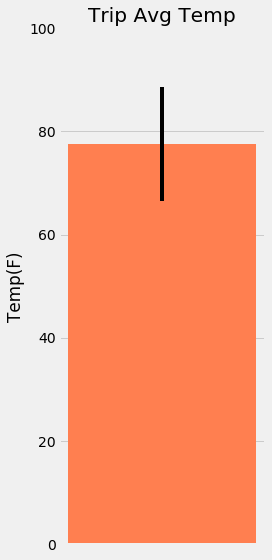

In [129]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


#fig, ax = plt.subplots(figsize=plt.figaspect(2.))
x = 1
yerr = tmax-tmin
y=tavg
plt.figure(figsize=(4,8))
plt.bar(x, y, yerr= yerr, color='coral', align="center")

plt.ylim (0,100)
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
ax = plt.axes()        
ax.xaxis.grid()
plt.xticks([])
plt.tight_layout()

plt.show()


In [131]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.949999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  6.149999999999999),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 3.67),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.1700000000000004),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.03),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.63),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.18)]

Temperature Analysis I

Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

T-tests are useful for comparing the means of two samples. There are two types: paired and unpaired.

Paired means that both samples consist of the same test subjects. A paired t-test is equivalent to a one-sample t-test.

Unpaired means that both samples consist of distinct test subjects. An unpaired t-test is equivalent to a two-sample t-test.

In [132]:


june_temps = session.query(Measurement.station,Measurement.tobs).filter(extract('month', Measurement.date) == 6)
june_results_list = [temp.tobs for temp in june_temps]
#print(june_results_list)
dec_temps = session.query(Measurement.station,Measurement.tobs).filter(extract('month', Measurement.date) == 12)
dec_results_list = [temp.tobs for temp in dec_temps]

from scipy import stats
stats.ttest_ind(june_results_list, dec_results_list)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

## Optional Challenge Assignment

In [133]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [83]:
daily_normals("01-02")

[(60.0, 69.39622641509433, 77.0)]

In [85]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

start_date = '2016-07-30'
end_date = '2016-08-07'


# Use the start and end date to create a range of dates
date_results = session.query(Measurement.date).distinct().\
    filter(Measurement.date >= '2016-07-30').filter(Measurement.date <= '2016-08-07').all()
print(date_results)

dates_list = list(np.ravel(date_results))
dates_list

# Stip off the year and save a list of %m-%d strings
new_dates_list = []
for date in dates_list:
    new_date = dt.datetime.strptime(date,"%Y-%m-%d")
    date1 = dt.datetime.strftime(new_date, '%m-%d')
    new_dates_list.append(date1)
new_dates_list

# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = []
for new_date in new_dates_list:
    normals = daily_normals(new_date)
    normals_list.append(normals)
normals_list


[('2016-07-30',), ('2016-07-31',), ('2016-08-01',), ('2016-08-02',), ('2016-08-03',), ('2016-08-04',), ('2016-08-05',), ('2016-08-06',), ('2016-08-07',)]


[[(69.0, 77.35185185185185, 84.0)],
 [(72.0, 77.03571428571429, 83.0)],
 [(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [135]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [134]:
# Plot the daily normals as an area plot with `stacked=False`

